In [1]:
import numpy as np
import random
from PIL import Image
from abc import ABC, abstractmethod
from collections import defaultdict
from itertools import cycle
import webcolors
import os

seed = 2

random.seed(seed)
np.random.seed(seed)

SPRITE_SIZE = 32

class GridEntity(ABC):
    """
    Base class for all entities in the gridworld environment.

    Attributes:
        sprite_cache (dict): A class-level cache for storing preloaded sprites.
        last_id (int): A class-level counter for assigning unique IDs to entities.
        id (int): Unique identifier for an instance of an entity.
        x (int): The x-coordinate of the entity on the grid.
        y (int): The y-coordinate of the entity on the grid.
        entity_type (str): The type of the entity (e.g., 'cars', 'lights').
        color (tuple): The RGB color of the entity.
        orientation (str): The orientation of the entity (e.g., 'up', 'down').
        speed (int): The speed of the entity.
        sprite_size (int): The size of the entity's sprite.
        sprite_path (str): The file path to the entity's sprite.
        state (str): The current state of the entity (specific to some entities like traffic lights).
        sprite (Image): The current sprite image of the entity.
    """
    sprite_cache = defaultdict(dict)
    last_id = 0

    @classmethod
    def preload_sprites(cls, colors_dict, orientations, sprite_path, sprite_size):
        """
        Preloads and caches the sprites for the entities.

        Args:
            colors_dict (dict): A dictionary mapping entity types to a list of colors.
            orientations (list): A list of possible orientations for the entities.
            sprite_path (str): The base path to the sprite images.
            sprite_size (int): The size to resize the sprites to.

        This method loads the sprites from the specified path, resizes them, and stores them in the class-level sprite cache.
        """
        for entity_type, colors in colors_dict.items():
            for color in colors:
                for orientation in orientations:
                    if entity_type == 'boulders':
                        img_path = f'{sprite_path}{entity_type}/boulder_{str(color)}.png'
                    elif entity_type == 'cars':
                        img_path = f'{sprite_path}{entity_type}/car_{str(color)}_(255, 255, 0).png'
                    elif entity_type == 'lights':
                        for state in ['red', 'green']:
                            img_path = f'{sprite_path}{entity_type}/light_{str(color)}_{state}.png'
                            cls._load_single_sprite(entity_type, color, orientation, img_path, state, sprite_size)
                        continue
                    cls._load_single_sprite(entity_type, color, orientation, img_path, None, sprite_size)

    @classmethod
    def _load_single_sprite(cls, entity_type, color, orientation, img_path, state, sprite_size):
        try:
            img = Image.open(img_path).convert('RGBA').resize((sprite_size, sprite_size))
            rotation = {'up': 180, 'down': 0, 'left': 270, 'right': 90}[orientation]
            cls.sprite_cache[entity_type][(str(color), orientation, state)] = img.rotate(rotation)
        except FileNotFoundError:
            print(f"File not found: {img_path}")

    @classmethod
    def load_sprite(cls, entity_type, color, orientation, state=None):
        """
        Loads a sprite from the cache based on the entity type, color, orientation, and state.

        Args:
            entity_type (str): The type of the entity.
            color (tuple): The RGB color of the entity.
            orientation (str): The orientation of the entity.
            state (str, optional): The current state of the entity, if applicable.

        Returns:
            Image: The loaded sprite image.
        """
        return cls.sprite_cache[entity_type][(str(color), orientation, state)]

    def __init__(self, x, y, entity_type, color, orientation=None, speed=1, sprite_path='sprites/', sprite_size=64):
        self.id = GridEntity.last_id
        GridEntity.last_id += 1
        self.x = x
        self.y = y
        self.entity_type = entity_type
        self.color = color
        self.orientation = orientation
        self.speed = speed
        self.sprite_size = sprite_size
        self.sprite_path = sprite_path
        self.state = None if entity_type != 'lights' else 'red'
        self.sprite = self.load_sprite(entity_type, color, orientation, self.state)

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def move_forward(self):
        if self.orientation == 'up':
            self.y -= self.speed
        elif self.orientation == 'down':
            self.y += self.speed
        elif self.orientation == 'left':
            self.x -= self.speed
        elif self.orientation == 'right':
            self.x += self.speed

    def turn_left(self):
        turns = {'up': 'left', 'left': 'down', 'down': 'right', 'right': 'up'}
        self.orientation = turns[self.orientation]
        self.sprite = self.sprite.rotate(90)

    def turn_right(self):
        turns = {'up': 'right', 'right': 'down', 'down': 'left', 'left': 'up'}
        self.orientation = turns[self.orientation]
        self.sprite = self.sprite.rotate(-90)

    def __repr__(self):
        return f"{self.entity_type} at ({self.x}, {self.y}) facing {self.orientation}"

class Vehicle(GridEntity):
    """
    Represents a vehicle in the gridworld environment.

    Inherits from GridEntity and adds specific attributes and methods related to vehicles.

    Attributes:
        size (int): The size of the vehicle.
    """
    def __init__(self, x, y, color, size, orientation, speed):
        """
        Initializes a Vehicle instance.

        Args:
            x (int): The x-coordinate of the vehicle.
            y (int): The y-coordinate of the vehicle.
            color (tuple): The color of the vehicle.
            size (int): The size of the vehicle.
            orientation (str): The orientation of the vehicle.
            speed (int): The speed of the vehicle.
        """
        super().__init__(x, y, 'cars', color, orientation, speed)
        self.size = size
        
    def predict_next_position(self):
        dx, dy = 0, 0
        if self.orientation == 'up':
            dy = -self.speed
        elif self.orientation == 'down':
            dy = self.speed
        elif self.orientation == 'left':
            dx = -self.speed
        elif self.orientation == 'right':
            dx = self.speed
        return self.x + dx, self.y + dy

    def set_speed(self, speed):
        self.speed = speed

    def intervene_rotation(self, new_orientation):
        if new_orientation not in ['up', 'down', 'left', 'right']:
            raise ValueError("Invalid orientation")
        self.orientation = new_orientation
        self.sprite = self.load_sprite(self.entity_type, self.color, self.orientation)


class Pedestrian(GridEntity):
    """
    Represents a pedestrian in the gridworld environment.

    Inherits from GridEntity with behaviors specific to pedestrians.

    The Pedestrian class may have additional behaviors or attributes specific to pedestrian dynamics in the gridworld.
    """
    def __init__(self, x, y, color, orientation=None, speed=1):
        """
        Initializes a Pedestrian instance.

        Args:
            x (int): The x-coordinate of the pedestrian.
            y (int): The y-coordinate of the pedestrian.
            color (tuple): The color of the pedestrian.
            orientation (str, optional): The orientation of the pedestrian. Defaults to None.
            speed (int): The speed of the pedestrian. Defaults to 1.
        """
        super().__init__(x, y, 'pedestrians', color, orientation, speed)

    def predict_random_walk(self):
        dx, dy = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
        return self.x + dx, self.y + dy

    def move_to(self, x, y):
        self.x = x
        self.y = y

class Obstacle(GridEntity):
    """
    Represents an obstacle in the gridworld environment.

    Inherits from GridEntity with properties specific to static obstacles in the environment.
    """
    def __init__(self, x, y, color, orientation='down', speed=0):
        """
        Initializes an Obstacle instance.

        Args:
            x (int): The x-coordinate of the obstacle.
            y (int): The y-coordinate of the obstacle.
            color (tuple): The color of the obstacle.
            orientation (str, optional): The orientation of the obstacle. Defaults to 'down'.
            speed (int, optional): The speed of the obstacle, typically zero for static obstacles. Defaults to 0.
        """
        super().__init__(x, y, 'boulders', color, orientation, speed)
    
    def move_to(self, x, y):
        self.x = x
        self.y = y
    

class TrafficLight(GridEntity):
    """
    Represents a traffic light in the gridworld environment.

    Inherits from GridEntity and includes traffic light specific properties and behaviors such as light state and frequency of state change.
    """
    def __init__(self, x, y, state, color, orientation=None, speed=0, frequency=None):
        """
        Initializes a TrafficLight instance.

        Args:
            x (int): The x-coordinate of the traffic light.
            y (int): The y-coordinate of the traffic light.
            state (str): The initial state of the traffic light ('red' or 'green').
            color (tuple): The color of the traffic light.
            orientation (str, optional): The orientation of the traffic light. Defaults to None.
            speed (int, optional): The speed of the traffic light, typically zero. Defaults to 0.
            frequency (tuple, optional): The frequency of state change, represented as a tuple (time in red, time in green). Defaults to None.
        """
        super().__init__(x, y, 'lights', color, orientation, speed)
        self.state = state
        self.frequency = frequency
        self.update_sprite()

    def update_sprite(self):
        self.sprite = self.load_sprite('lights', self.color, self.orientation, self.state)

    def update(self, step):
        if not self.frequency:
            return
        if step % sum(self.frequency) < self.frequency[0]:
            self.state = 'red'
        else:
            self.state = 'green'
        self.update_sprite()

    def change_orientation(self, new_orientation):
        if new_orientation not in ['up', 'down', 'left', 'right']:
            raise ValueError("Invalid orientation")
        self.orientation = new_orientation
        self.update_sprite()
    
    def _populate_tl_sprite_cache(self):
        # Iterate over each orientation and state to create and cache sprites
        for orient in ['up', 'down', 'left', 'right']:
            # Load the base sprite for the current orientation
            base_sprite = self.load_sprite(self.symbol, orient, self.sprite_path, self.sprite_size)

            # Create and cache the red and green sprites for this orientation
            red_sprite = Image.blend(base_sprite, Image.new('RGBA', base_sprite.size, (255, 0, 0, 128)), 0.5)
            green_sprite = Image.blend(base_sprite, Image.new('RGBA', base_sprite.size, (0, 255, 0, 128)), 0.5)

            # Cache the sprites with keys as (orientation, state)
            self.traffic_light_sprite_cache[(orient, 'red')] = red_sprite
            self.traffic_light_sprite_cache[(orient, 'green')] = green_sprite

    def intervene_state(self):
        self.state = 'green' if self.state == 'red' else 'red'
        self.update_sprite()
    
    def __repr__(self):
        return f"Traffic light at ({self.x}, {self.y}) facing {self.orientation} with state {self.state}."


class Gridworld:
    """
    Represents the gridworld environment, a simulation space for various entities like vehicles, pedestrians, traffic lights, and obstacles.

    The Gridworld class is responsible for managing the environment's grid layout, tracking entity positions, handling entity interactions, and updating the state of the world through each simulation step. It offers functionalities to add and move entities within the grid, execute interventions, and render the environment's current state.

    Attributes:
        width (int): The width of the grid in the gridworld.
        height (int): The height of the grid in the gridworld.
        grid (ndarray): A numpy array representing the grid layout with entity symbols.
        entity_map (defaultdict of list): A dictionary mapping grid positions (x, y) to a list of entities at that position.
        entity_groups (dict): A dictionary grouping entities by type for efficient processing.
        step_count (int): Counter for the number of steps taken in the simulation.
        sprite_size (int): The size of the sprites used for rendering entities.

    Core Functions:
        - add_entity: Adds an entity to the gridworld.
        - step: Advances the state of the gridworld by one time step.
        - semi_random_intervention: Performs a semi-random intervention on an entity.
        - randomly_initialize: Initializes the gridworld with a random configuration of entities.
        - render: Generates a visual representation of the current state of the gridworld.
    """
    
    color_name_cache = {}
    
    @classmethod
    def get_possible_intervention(cls, entity):
        if isinstance(entity, Vehicle):
            return ['turn']
        elif isinstance(entity, TrafficLight):
            return ['change_orientation', 'change_state']
        elif isinstance(entity, Pedestrian):
            return ['move_to']
        elif isinstance(entity, Obstacle):
            return ['move_to']

    @property
    def entities(self):
        return [entity for entities in self.entity_map.values() for entity in entities]

    def __init__(self, width, height, sprite_size=SPRITE_SIZE):
        """
        Initializes a Gridworld instance.

        Args:
            width (int): The width of the gridworld.
            height (int): The height of the gridworld.
            sprite_size (int, optional): The size of the sprites in the gridworld. Defaults to SPRITE_SIZE.
        """
        self.width = width
        self.height = height
        self.grid = np.full((height, width), ' ', dtype='<U1')
        self.entity_map = defaultdict(list)
        self.entity_groups = None
        self.step_count = 0
        self.sprite_size = sprite_size

    def add_entity(self, entity):
        self.entity_map[(entity.x, entity.y)].append(entity)

    def move_entity(self, entity, new_x, new_y):
        if self.is_cell_free(new_x, new_y) and 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.entity_map[(entity.x, entity.y)].remove(entity)
            entity.set_position(new_x, new_y)
            self.entity_map[(new_x, new_y)].append(entity)

    def update_grid(self):
        self.grid.fill(' ')
        for entity in self.entities:
            if 0 <= entity.x < self.width and 0 <= entity.y < self.height:
                self.grid[entity.y][entity.x] = entity.symbol

    def display(self):
        for row in self.grid:
            print(' '.join(row))

    def step(self):
        """
        Advances the state of the gridworld by one time step.

        During each step, this method updates the positions and states of all entities in the gridworld according to their behaviors and interactions. It also handles the logic for traffic lights, entity movements, and collisions.
        
        This is the main method used to progress the simulation and should be called repeatedly in a loop to simulate continuous time.
        """
        if not self.entity_groups:
            self._build_entity_groups()
        self.step_count += 1

        # Update traffic lights based on step count
        # for position, entities in list(self.entity_map.items()):
        #     for entity in entities:
        #         if isinstance(entity, TrafficLight):
        #             entity.update(self.step_count)

        # Enforce traffic rules
        self.enforce_traffic_rules()
        # self.randomly_change_car_orientation()
        # Temporary structure to store entity movements
        movements = []

        # Update each entity
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    next_x, next_y = entity.predict_next_position()
                    movements.append((entity, next_x, next_y))
                elif isinstance(entity, Pedestrian):
                    next_x, next_y = entity.predict_random_walk()
                    movements.append((entity, next_x, next_y))
                # elif isinstance(entity, TrafficLight):
                #     entity.update(self.step_count)

        # Apply movements
        for entity, next_x, next_y in movements:
            self.move_entity(entity, next_x, next_y)

        # Handle collisions
        self.handle_collisions()

    def intervene(self, entity, intervention, **intervention_args):
        if isinstance(entity, Vehicle):
            if intervention == 'turn':
                entity.intervene_rotation(intervention_args['new_orientation'])
        elif isinstance(entity, TrafficLight):
            if intervention == 'change_orientation':
                entity.change_orientation(intervention_args['new_orientation'])
            elif intervention == 'change_state':
                entity.intervene_state()
        elif isinstance(entity, Pedestrian):
            if intervention == 'move_to':
                self.move_entity(entity, intervention_args['x'], intervention_args['y'])
        elif isinstance(entity, Obstacle):
            if intervention == 'move_to':
                self.move_entity(entity, intervention_args['x'], intervention_args['y'])
    
    def random_intervention(self):
        entity = random.choice(self.entities)
        possible_interventions = self.get_possible_intervention(entity)
        intervention = random.choice(possible_interventions)
        if intervention == 'turn':
            new_orientation = random.choice(['up', 'down', 'left', 'right'])
            self.intervene(entity, intervention, new_orientation=new_orientation)
        elif intervention == 'change_orientation':
            new_orientation = random.choice(['up', 'down', 'left', 'right'])
            self.intervene(entity, intervention, new_orientation=new_orientation)
        elif intervention == 'change_state':
            self.intervene(entity, intervention)
        elif intervention == 'move_to':
            # Pick a random cell around the entity that is free
            x, y = entity.x, entity.y
            possible_moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            possible_moves = [(x, y) for x, y in possible_moves if self.is_cell_free(x, y)]
            if possible_moves:
                new_x, new_y = random.choice(possible_moves)
                self.intervene(entity, intervention, x=new_x, y=new_y)

    @staticmethod
    def closest_color(requested_color):
        min_colors = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]

    @staticmethod
    def get_color_name(rgb_tuple):
        # Check cache first
        if rgb_tuple in Gridworld.color_name_cache:
            return Gridworld.color_name_cache[rgb_tuple]

        # If not in cache, compute and store in cache
        try:
            color_name = webcolors.rgb_to_name(rgb_tuple)
        except ValueError:
            color_name = Gridworld.closest_color(rgb_tuple)

        Gridworld.color_name_cache[rgb_tuple] = color_name
        return color_name

    @staticmethod
    def describe_action(causals, action):
        ACTION_MAPPING = {1: 'turned', 2: 'changed the state of', 3: 'moved'}

        if action == (-1, -1, -1):
            return "No action was performed."

        action_pos, action_code = action[:2], action[2]

        entity_description = ""
        for key, value in causals.items():
            if 'position' in key and value == action_pos:
                entity_type, entity_color = key.split('_')[:2]
                # Convert RGB string to tuple
                rgb_tuple = tuple(map(int, entity_color[1:-1].split(', ')))
                color_name = Gridworld.get_color_name(rgb_tuple)
                entity_description = f"{color_name} {entity_type}"
                break

        if entity_description:
            action_desc = ACTION_MAPPING.get(action_code, 'performed an action on')
            return f"You {action_desc} the {entity_description}."
        else:
            return "The action did not match any entity."

    def semi_random_intervention(self, intervention_probabilities = {
            'Vehicle': 0.4, 'TrafficLight': 0.4, 'Obstacle': 0.1, 'None': 0.1
        }):
        """
        Performs a semi-random intervention on a randomly chosen entity in the gridworld.

        The intervention could involve changing the state of a light, the orientation of a car, and the position of a boulder. The choice of entity and intervention type is semi-random, based on predefined probabilities.

        Returns:
            tuple: A tuple containing the action code and a dictionary of binary interventions applied.
        """
        causals = self.get_causals()
        binary_interventions = {key: 0 for key in causals.keys()}  # Use dictionary for binary interventions
        action_code = (-1, -1, -1)
        # Define the action mapping
        ACTION_MAPPING = {'turn': 1, 'change_state': 2, 'move_to': 3}
        
        assert sum(intervention_probabilities.values()) == 1, "Intervention probabilities must sum to 1."

        # Select an entity type based on the defined probabilities
        entity_type = np.random.choice(list(intervention_probabilities.keys()), p=list(intervention_probabilities.values()))
        
        if entity_type == 'None':
            return action_code, binary_interventions
        
        # Select a random entity of the selected type
        entity = random.choice([entity for entity in self.entities if entity.__class__.__name__ == entity_type])
        
        if isinstance(entity, Vehicle):
            next_pos = entity.predict_next_position()
            if not self.is_cell_free(*next_pos):
                obstacle = self.get_entity_at_position(*next_pos)
                if obstacle and isinstance(obstacle, Obstacle):
                    # Move the obstacle
                    possible_moves = self.get_free_cells_around_entity(obstacle)
                    if possible_moves:
                        new_x, new_y = random.choice(possible_moves)
                        self.intervene(obstacle, 'move_to', x=new_x, y=new_y)
                        binary_interventions[f'obstacle_{obstacle.color}_position'] = 1
                        action_code = (obstacle.x, obstacle.y, ACTION_MAPPING['move_to'])
                else:
                    if random.random() < 0.3:
                        # Turn the car
                        current_orientation = entity.orientation
                        new_orientation_choices = {'up': ['left', 'right'], 'down': ['left', 'right'], 'left': ['up', 'down'], 'right': ['up', 'down']}[current_orientation]
                        new_orientation = random.choice(new_orientation_choices)
                        self.intervene(entity, 'turn', new_orientation=new_orientation)
                        binary_interventions[f'vehicle_{entity.color}_orientation'] = 1
                        action_code = (entity.x, entity.y, ACTION_MAPPING['turn'])
                    else:
                        # Do nothing
                        pass
            else:
                # Turn the car
                current_orientation = entity.orientation
                new_orientation_choices = {'up': ['left', 'right'], 'down': ['left', 'right'], 'left': ['up', 'down'], 'right': ['up', 'down']}[current_orientation]
                new_orientation = random.choice(new_orientation_choices)
                self.intervene(entity, 'turn', new_orientation=new_orientation)
                binary_interventions[f'vehicle_{entity.color}_orientation'] = 1
                action_code = (entity.x, entity.y, ACTION_MAPPING['turn'])
        if isinstance(entity, TrafficLight):
            # Change the state of the traffic light
            self.intervene(entity, 'change_state')
            binary_interventions[f'trafficlight_{entity.color}_state'] = 1
            action_code = (entity.x, entity.y, ACTION_MAPPING['change_state'])
        if isinstance(entity, Obstacle):
            # Move the obstacle to a random free cell
            possible_moves = self.get_free_cells_around_entity(entity)
            if possible_moves:
                new_x, new_y = random.choice(possible_moves)
                self.intervene(entity, 'move_to', x=new_x, y=new_y)
                binary_interventions[f'obstacle_{entity.color}_position'] = 1
                action_code = (entity.x, entity.y, ACTION_MAPPING['move_to'])
        description = f"You intervened on a {entity_type}_{entity.color} at ({entity.x}, {entity.y}) with action {action_code}."
        return action_code, binary_interventions

    
    def randomly_change_car_orientation(self):
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    if random.random() < 0.1:
                        if random.random() < 0.5:
                            entity.turn_left()
                        else:
                            entity.turn_right()                        


    def move_vehicle(self, vehicle):
        next_x, next_y = vehicle.predict_next_position()
        self.move_entity(vehicle, next_x, next_y)

    def move_pedestrian(self, pedestrian):
        next_x, next_y = pedestrian.predict_random_walk()
        self.move_entity(pedestrian, next_x, next_y)

    def handle_collisions(self):
        for pos, entities in self.entity_map.items():
            if len(entities) > 1:
                for entity1 in entities:
                    for entity2 in entities:
                        if entity1 != entity2:
                            self.resolve_collision(entity1, entity2)

    def resolve_collision(self, entity1, entity2):
        if isinstance(entity1, Vehicle) and isinstance(entity2, Vehicle):
            entity1.set_speed(0)
            entity2.set_speed(0)
            print(f"Collision between {entity1.entity_type} and {entity2.entity_type} at ({entity1.x}, {entity1.y})")

    def enforce_traffic_rules(self):
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    self.check_traffic_light(entity)

    def check_traffic_light(self, vehicle):
        vehicle.set_speed(1)
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, TrafficLight):
                    if self.is_light_ahead(vehicle, entity):
                        if entity.state == 'red':
                            vehicle.set_speed(0)
                        else:
                            vehicle.set_speed(1)
                    # else:
                    #     vehicle.set_speed(1)


    def is_light_ahead(self, vehicle, light):
        dx, dy = vehicle.predict_next_position()
        if vehicle.orientation == 'up' and light.orientation == 'down':
            return light.y < vehicle.y and light.x == vehicle.x
        elif vehicle.orientation == 'down' and light.orientation == 'up':
            return light.y > vehicle.y and light.x == vehicle.x
        elif vehicle.orientation == 'left' and light.orientation == 'right':
            return light.x < vehicle.x and light.y == vehicle.y
        elif vehicle.orientation == 'right' and light.orientation == 'left':
            return light.x > vehicle.x and light.y == vehicle.y
        return False

    def is_cell_free(self, x, y):
        return not self.entity_map[(x, y)]

    def get_free_cells_around_entity(self, entity):
        x, y = entity.x, entity.y
        possible_moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        possible_moves = [(x, y) for x, y in possible_moves if self.is_cell_free(x, y)]
        return possible_moves

    def get_entity_at_position(self, x, y):
        if self.entity_map[(x, y)]:
            return self.entity_map[(x, y)][0]
        return None

    def render(self):
        sprite_size = self.sprite_size
        env_img = Image.new('RGBA', (self.width * sprite_size, self.height * sprite_size), "black")
        for entities in self.entity_map.values():
            for entity in entities:
                img = entity.sprite
                x, y = entity.x * sprite_size, entity.y * sprite_size
                env_img.paste(img, (x, y), img)
        # Include grid lines
        # for i in range(1, self.width):
        #     env_img.paste((0, 0, 0, 255), (i * sprite_size, 0, i * sprite_size + 1, self.height * sprite_size))
        # for i in range(1, self.height):
        #     env_img.paste((0, 0, 0, 255), (0, i * sprite_size, self.width * sprite_size, i * sprite_size + 1))
       
        # Paint the transparent background black
        env_img = env_img.convert('RGB')
        return env_img

    def randomly_initialize(self, car_colors, light_colors, boulder_colors, num_cars=5, num_lights=5, num_boulders=5, x_percent=80, y_percent=10, z_percent=30, fixed_light_positions=[]):
        """
        Initializes the gridworld with a random configuration of vehicles, traffic lights, and obstacles.

        Args:
            car_colors (list): A list of colors available for cars.
            light_colors (list): A list of colors available for traffic lights.
            boulder_colors (list): A list of colors available for boulders.
            num_cars (int, optional): The number of cars to initialize. Defaults to 5.
            num_lights (int, optional): The number of traffic lights to initialize. Defaults to 5.
            num_boulders (int, optional): The number of boulders to initialize. Defaults to 5.
            x_percent (int, optional): Percentage of grid size for minimum distance between cars and lights. Defaults to 80.
            y_percent (int, optional): Percentage of grid size for minimum distance between cars and boulders. Defaults to 10.
            z_percent (int, optional): Percentage of boulders to be placed between cars and lights. Defaults to 30.
            fixed_light_positions (list of tuples, optional): Fixed positions for traffic lights. Defaults to an empty list.

        This method sets up an initial layout for the gridworld, placing entities at random or specified positions while considering specified constraints and parameters.
        """
        grid_size = self.width  # Assuming width and height are the same
        min_dist_from_edge = lambda percent: int(percent / 100 * grid_size)
        x_percent, y_percent = list(map(lambda x: round(grid_size * x / 100), [x_percent, y_percent]))

        # Verify that we have enough colors for each entity type
        assert len(car_colors) >= num_cars, "Not enough unique car colors available."
        assert len(light_colors) >= num_lights, "Not enough unique light colors available."
        assert len(boulder_colors) >= num_boulders, "Not enough unique boulder colors available."
        
        # Shuffle colors and create iterators
        random.shuffle(car_colors)
        # random.shuffle(light_colors)
        random.shuffle(boulder_colors)

        car_colors_iter = cycle(car_colors)
        light_colors_iter = cycle(light_colors)
        boulder_colors_iter = cycle(boulder_colors)

        for (light_x, light_y, light_orientation) in fixed_light_positions:
            light_color = next(light_colors_iter)
            light = TrafficLight(light_x, light_y, 'red', light_color, light_orientation, frequency=(100, 1))
            self.add_entity(light)

            car_orientation = self.get_opposite_orientation(light_orientation)
            car_x, car_y = self.calculate_light_position(light_x, light_y, light_orientation, min_dist=x_percent, grid_size=grid_size)
            car_color = next(car_colors_iter)
            vehicle = Vehicle(car_x, car_y, car_color, size=1, orientation=car_orientation, speed=1)
            self.add_entity(vehicle)

        for _ in range(num_cars - len(fixed_light_positions)):
            orientation = random.choice(['up', 'down', 'left', 'right'])
            min_dist = min_dist_from_edge(x_percent)

            if orientation == 'up':
                y = random.randint(min_dist, grid_size - 1)
                x = random.randint(0, grid_size - 1)
            elif orientation == 'down':
                y = random.randint(0, grid_size - min_dist - 1)
                x = random.randint(0, grid_size - 1)
            elif orientation == 'left':
                x = random.randint(min_dist, grid_size - 1)
                y = random.randint(0, grid_size - 1)
            else:  # right
                x = random.randint(0, grid_size - min_dist - 1)
                y = random.randint(0, grid_size - 1)

            car_color = next(car_colors_iter)
            vehicle = Vehicle(x, y, car_color, size=1, orientation=orientation, speed=1)
            self.add_entity(vehicle)

            light_color = next(light_colors_iter)
            light_x, light_y = self.calculate_light_position(x, y, orientation, min_dist=y_percent, grid_size=grid_size)
            light = TrafficLight(light_x, light_y, 'red', light_color, self.get_opposite_orientation(orientation), frequency=(100, 1))
            self.add_entity(light)

        occupied_positions = set(self.entity_map.keys())

        for _ in range(num_boulders):
            x, y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)
            if random.randint(0, 100) < z_percent:
                car = random.choice([entity for entity in self.entities if isinstance(entity, Vehicle)])
                light_x, light_y = self.calculate_light_position(car.x, car.y, car.orientation, min_dist=y_percent, grid_size=grid_size)
                boulder_x, boulder_y = (car.x + light_x) // 2, (car.y + light_y) // 2  # Place boulder halfway between car and light
            else:
                while True:
                    boulder_x, boulder_y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)
                    if (boulder_x, boulder_y) not in occupied_positions:
                        break

            boulder_color = next(boulder_colors_iter)
            boulder = Obstacle(boulder_x, boulder_y, boulder_color)
            self.add_entity(boulder)


    def get_causals(self, are_light_positions_fixed=True):
        """
        Returns a dictionary of causal variables and their values
        The causal variables are:
        1. Car positions
        2. Car orientations
        3. Traffic light positions (if not fixed)
        4. Traffic light states
        5. Traffic light orientations (if not fixed)
        6. Pedestrian positions
        7. Obstacle positions
        """
        causal_dict = {}
        for entity in self.entities:
            # Using the class name to determine the type of the entity
            entity_class_name = entity.__class__.__name__.lower()
            base_key = f'{entity_class_name}_{entity.color}'
            causal_dict[f'{base_key}_position'] = (entity.x, entity.y)
            if not isinstance(entity, Obstacle):
                causal_dict[f'{base_key}_orientation'] = entity.orientation
            # causal_dict[f'{base_key}_color'] = entity.color
            if isinstance(entity, TrafficLight):
                causal_dict[f'{base_key}_state'] = entity.state
        return causal_dict

    def get_causal_vector(self, are_light_positions_fixed=True):
        """
        Returns a vector representation of the causal variables
        Positions are flattened and normalized to be between 0 and 1
        Orientations are converted to radians
        States are converted to binary
        """
        causals = self.get_causals()
        causal_vector = []
        for key, value in sorted(causals.items()):
            if 'position' in key:
                # Normalize positions
                causal_vector.extend([value[0] / (self.width - 1), value[1] / (self.height - 1)])
            elif 'orientation' in key:
                # Convert orientations to radians
                orientation_to_radians = {'up': 0, 'right': np.pi / 2, 'down': np.pi, 'left': 3 * np.pi / 2}
                causal_vector.append(orientation_to_radians[value])
            elif 'state' in key:
                # Convert states to binary
                state_to_binary = {'red': 1, 'green': 0}
                causal_vector.append(state_to_binary[value])
        return causal_vector
    
    def causal_vector_to_causals(self, causal_vector):
        """
        Inverses the causal vector representation to a dictionary of causal variables and their values
        back to the original representation
        """
        causals = self.get_causals()
        causal_dict = {}
        i = 0
        for key in sorted(causals.keys()):
            if 'position' in key:
                # Reverse normalization of positions
                x, y = causal_vector[i] * self.width, causal_vector[i + 1] * self.height
                causal_dict[key] = (int(round(x)), int(round(y)))
                i += 2
            elif 'orientation' in key:
                # Convert radians back to orientations
                radians_to_orientation = {0: 'up', np.pi / 2: 'right', np.pi: 'down', 3 * np.pi / 2: 'left'}
                causal_dict[key] = radians_to_orientation[causal_vector[i]]
                i += 1
            elif 'state' in key:
                # Convert binary back to states
                binary_to_state = {1: 'red', 0: 'green'}
                causal_dict[key] = binary_to_state[causal_vector[i]]
                i += 1
        return causal_dict


    def causal_vector_to_debug_dict(gridworld, causal_vector):
        """
        Inverse the causal vector representation to a dictionary of causal variables and their values
        to the flattened representation for debugging
        """
        causals = gridworld.get_causals()
        debug_dict = {}
        i = 0
        for key in sorted(causals.keys()):
            if 'position' in key:
                # Separate entries for x and y positions
                debug_dict[f'{key}_x'] = causal_vector[i]
                debug_dict[f'{key}_y'] = causal_vector[i + 1]
                i += 2
            elif 'orientation' in key:
                # Orientation as radians
                debug_dict[key] = causal_vector[i]
                i += 1
            elif 'state' in key:
                # State as binary
                debug_dict[key] = causal_vector[i]
                i += 1
        return debug_dict
        
    @staticmethod
    def interventions_to_binary_vector(interventions, causals):
        binary_vector = []
        for key in sorted(causals.keys()):
            if 'position' in key:
                # Check if position (either x or y) was intervened
                entity_key = key.rsplit('_', 1)[0]  # Get the base entity key without '_position'
                intervened = f'{entity_key}_position' in interventions and interventions[f'{entity_key}_position'] == 1

                # If position was intervened, set both x and y to 1
                binary_vector.extend([1, 1] if intervened else [0, 0])
            else:
                # For other types of interventions (like orientation or state)
                intervened = key in interventions and interventions[key] == 1
                binary_vector.append(1 if intervened else 0)

        return binary_vector
    
    @staticmethod
    def get_opposite_orientation(orientation):
        return {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}[orientation]

    @staticmethod
    def calculate_light_position(x, y, orientation, min_dist=10, max_dist=20, grid_size=50):
        max_dist = min(max_dist, grid_size - 1)
        # Generate a random distance within the specified range
        distance = random.randint(min_dist, max_dist)
        # Calculate the offset based on orientation
        offset_x, offset_y = {'up': (0, -distance), 'down': (0, distance), 
                            'left': (-distance, 0), 'right': (distance, 0)}[orientation]

        # Calculate the new position and ensure it is within grid boundaries
        light_x = min(max(x + offset_x, 0), grid_size - 1)
        light_y = min(max(y + offset_y, 0), grid_size - 1)

        return light_x, light_y
    
    def _build_entity_groups(self):
        entity_groups = defaultdict(list)
        for entity in gridworld.entities:
            entity_groups[entity.entity_type].append(entity)
        self.entity_groups = entity_groups

from sprite_maker import make_sprites

# colors = [
#     (255, 0, 0),     # Red
#     # (0, 255, 0),     # Green
#     (0, 0, 255),     # Blue
#     # (255, 255, 0),   # Yellow
#     # (255, 0, 255),   # Magenta
#     (0, 255, 255),   # Cyan
#     # (128, 0, 0),     # Dark Red
#     # (0, 128, 0),     # Dark Green
#     # (0, 0, 128),     # Dark Blue
#     # (128, 128, 0),   # Olive
#     # (128, 0, 128),   # Purple
#     # (0, 128, 128),   # Teal
#     (192, 192, 192), # Silver
#     # (128, 128, 128), # Gray
#     (255, 165, 0),   # Orange
#     # (255, 20, 147),  # Deep Pink
#     # (0, 255, 127),   # Spring Green
#     # (0, 191, 255),   # Deep Sky Blue
#     # (138, 43, 226),  # Blue Violet
# ]

# Define specific color subsets for each entity type
car_colors = [
    (255, 0, 0), # Red
    (0, 0, 255), # Blue
    # (0, 255, 255), # Cyan
    (192, 192, 192), # Silver
    # (255, 165, 0), # Orange
]
light_colors = [
    # (0, 0, 255), # Blue
    (0, 255, 255), # Cyan
    (192, 192, 192), # Silver
    # (255, 165, 0), # Orange
    (100, 100, 0), # Dark Olive
]
boulder_colors = [
    (255, 0, 0), # Red
    # (0, 0, 255), # Blue
    (0, 255, 255), # Cyan
    # (192, 192, 192), # Silver
    (255, 165, 0), # Orange
]

# make_sprites(car_colors, light_colors, boulder_colors)

# Preload sprites for each entity type with their specific color subsets
colors_dict = {
    'cars': car_colors,
    'lights': light_colors,
    'boulders': boulder_colors
}
orientations = ['up', 'down', 'left', 'right']
GridEntity.preload_sprites(colors_dict, orientations, sprite_path='sprites/', sprite_size=SPRITE_SIZE)
# Create an instance of Gridworld
grid_x, grid_y = 8, 8  # Set the size of the grid
gridworld = Gridworld(grid_x, grid_y, sprite_size=SPRITE_SIZE)


# Create 5 fixed light positions
fixed_light_positions = [(0, 0, 'down'), (3, grid_y - 1, 'up'), (grid_x - 3, 0, 'down')]#, (grid_x - 5, grid_y - 4, 'up'), (grid_x // 2, grid_y // 2, 'up')]

# Initialize the gridworld with vehicles, traffic lights, and boulders
gridworld.randomly_initialize(car_colors, light_colors, boulder_colors, num_cars=3, num_lights=3, num_boulders=3, fixed_light_positions=fixed_light_positions, x_percent=50, y_percent=10, z_percent=30)




gridworld.step()  # Initial step to set up the environment
initial_frame = gridworld.render()
initial_causal_vector = gridworld.get_causal_vector(are_light_positions_fixed=True)

frames = [initial_frame.copy()]  # List of frames, starting with the initial frame
causals = [initial_causal_vector]  # List of causals, starting with the initial state
actions = []  # List of actions
action_descriptions = []  # List of action descriptions
interventions = []  # List of interventions


if not os.path.exists('frames'):
    os.makedirs('frames')

# Generation loop
for _ in range(1, 25):  # Start from 1 since we already have the initial state
    action, intervention = gridworld.semi_random_intervention()
    pre_step_causals = gridworld.get_causals()
    gridworld.step()
    
    # Append action and intervention information
    actions.append(action)
    interventions.append(gridworld.interventions_to_binary_vector(intervention, gridworld.get_causals()))

    # Append causal information
    causals.append(gridworld.get_causal_vector(are_light_positions_fixed=True))
    
    # Append action description
    action_description = gridworld.describe_action(pre_step_causals, action)
    action_descriptions.append(action_description)

    # Render and save the frame
    frame = gridworld.render()
    frame_name = f"{seed}_{gridworld.step_count}.png"
    frame.save(f"frames/{frame_name}")
    frames.append(frame.copy())

# Save the frames as a GIF
frames[0].save('gridworld_random.gif', save_all=True, append_images=frames[1:], duration=300, loop=0, disposal=2)

In [ ]:
frames[0]

In [ ]:
import json
dataset_name = 'gridworld_small'
object_names = ['_'.join(a.split('_')[:-1]) for a in sorted(gridworld.get_causals())]
action_types = ['turn', 'change_state', 'move_to']
flattened_causals = list(gridworld.causal_vector_to_debug_dict(causals[0]).keys())
causal_keys = list(gridworld.get_causals().keys())
are_interventions_stochastic = True
metadata = {
    'object_names': object_names,
    'action_types': action_types,
    'causal_keys': causal_keys,
    'flattened_causals': flattened_causals,
    'are_interventions_stochastic': are_interventions_stochastic,
}

# Save the metadata
for split in ('train', 'val', 'test_indep'):
    with open(f'data/{dataset_name}/{split}_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

# Usage
# visualize_episode(gridworld, frames, causals, actions, action_descriptions, interventions)

In [ ]:
import multiprocessing
import random
from functools import partial
import os

def run_simulation(seed, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):

    random.seed(seed)
    np.random.seed(seed)
    
    car_colors = [
        (255, 0, 0), # Red
        (0, 0, 255), # Blue
        # (0, 255, 255), # Cyan
        (192, 192, 192), # Silver
        # (255, 165, 0), # Orange
    ]
    light_colors = [
        # (0, 0, 255), # Blue
        (0, 255, 255), # Cyan
        (192, 192, 192), # Silver
        # (255, 165, 0), # Orange
        (100, 100, 0), # Dark Olive
    ]
    boulder_colors = [
        (255, 0, 0), # Red
        # (0, 0, 255), # Blue
        (0, 255, 255), # Cyan
        # (192, 192, 192), # Silver
        (255, 165, 0), # Orange
    ]

    # Preload sprites for each entity type with their specific color subsets
    colors_dict = {
        'cars': car_colors,
        'lights': light_colors,
        'boulders': boulder_colors
    }
    orientations = ['up', 'down', 'left', 'right']
    GridEntity.preload_sprites(colors_dict, orientations, sprite_path='sprites/', sprite_size=sprite_size)

    # Create an instance of Gridworld
    gridworld = Gridworld(grid_x, grid_y, sprite_size=sprite_size)

    # Initialize the gridworld with vehicles, traffic lights, and boulders
    gridworld.randomly_initialize(car_colors, light_colors, boulder_colors, num_cars=3, num_lights=3, num_boulders=3, fixed_light_positions=fixed_light_positions, x_percent=50, y_percent=10, z_percent=20)

    # Run the simulation
    gridworld.step()  # Initial step to set up the environment
    initial_frame = gridworld.render()
    initial_causal_vector = gridworld.get_causal_vector(are_light_positions_fixed=True)

    frames = [initial_frame.copy()]  # List of frames, starting with the initial frame
    causals = [initial_causal_vector]  # List of causals, starting with the initial state
    actions = []  # List of actions
    action_descriptions = []  # List of action descriptions
    interventions = []  # List of interventions

    # Generation loop
    for _ in range(1, 20):  # Start from 1 since we already have the initial state
        action, intervention = gridworld.semi_random_intervention()
        gridworld.step()
        
        # Append action and intervention information
        actions.append(action)
        interventions.append(gridworld.interventions_to_binary_vector(intervention, gridworld.get_causals()))

        # Append causal information
        causals.append(gridworld.get_causal_vector(are_light_positions_fixed=True))
        
        # Append action description
        action_description = gridworld.describe_action(gridworld.get_causals(), action)
        action_descriptions.append(action_description)

        # Render and save the frame
        frame = gridworld.render()
        # frame_name = f"{seed}_{gridworld.step_count}.png"
        # frame.save(f"frames/{frame_name}")
        frames.append(frame.copy())
    
    # Create a directory if it doesn't exist
    if not os.path.exists(f'data/{dataset_name}/{split}'):
        os.makedirs(f'data/{dataset_name}/{split}', exist_ok=True)
    
    np.savez_compressed(f'data/{dataset_name}/{split}/gridworld_episode_{seed}.npz', 
                frames=np.array(frames),
                causals=np.array(causals),
                actions=np.array(actions),
                interventions=np.array(interventions))
    
    # frames[0].save(f'gifs/gridworld_random_{seed}.gif', save_all=True, append_images=frames[1:], duration=300, loop=0, disposal=2)


from multiprocessing import Pool
from tqdm.notebook import tqdm

def run_batch(batch_seeds, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):
    for seed in batch_seeds:
        run_simulation(seed, split, dataset_name, grid_x, grid_y, sprite_size, fixed_light_positions)

def gen_data(seeds, batch_size, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):
    run_batch_split = partial(run_batch, split=split, dataset_name=dataset_name, grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
    batches = [seeds[i:i + batch_size] for i in range(0, len(seeds), batch_size)]
    
    with Pool() as pool:
        # Wrap pool.map with tqdm for progress tracking
        list(tqdm(pool.imap_unordered(run_batch_split, batches), total=len(batches)))

def main():
    # # Train split
    grid_x, grid_y = 8, 8
    sprite_size = 32
    fixed_light_positions = [(0, 0, 'down'), (3, grid_y - 1, 'up'), (grid_x - 3, 0, 'down')]
    train_seeds = 1000
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds)

    gen_data(seeds, batch_size, 'train', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
        
    # # Validation split
    val_seeds = 100
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds, train_seeds + val_seeds)
    
    gen_data(seeds, batch_size, 'val', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
    
    # Test split
    test_seeds = 100
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds + val_seeds, train_seeds + val_seeds + test_seeds)
    
    gen_data(seeds, batch_size, 'test', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
main()

In [ ]:
original_causals = gridworld.get_causals()
causal_vector = causals[-1]
converted_causals = gridworld.causal_vector_to_causals(causal_vector)

all_keys_match = sorted(original_causals.keys()) == sorted(converted_causals.keys())
all_values_match = all([original_causals[key] == converted_causals[key] for key in original_causals])

all_keys_match and all_values_match

In [ ]:
from matplotlib import pyplot as plt
# Convert frame to numpy array
frame_np = np.array(frames[0])
print(frame_np.shape)
# Turn the transparent background into white
frame_np[frame_np[:, :, 3] == 0] = 0
plt.imshow(frame_np)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define nodes for the graph
nodes = [
    'vehicle1_pos', 'vehicle1_or',
    'vehicle2_pos', 'vehicle2_or',
    'light1_state', 'light1_or',
    'light2_state', 'light2_or',
    'boulder1_pos', 'boulder2_pos'
]

# Extend nodes to include both t and t+1
extended_nodes = [f"{node}_t" for node in nodes] + [f"{node}_t+1" for node in nodes]

# Initialize the adjacency matrix for the extended nodes
extended_adj_matrix = np.zeros((len(extended_nodes), len(extended_nodes)))

# Define the indices for the extended nodes
extended_node_indices = {node: i for i, node in enumerate(extended_nodes)}

for node in nodes:
    # Adding temporal edges
    extended_adj_matrix[extended_node_indices[f'{node}_t'], extended_node_indices[f'{node}_t+1']] = 1

# Adding causal edges based on relationships
for vehicle in ['vehicle1', 'vehicle2']:
    for other_vehicle in ['vehicle1', 'vehicle2']:
        if vehicle != other_vehicle:
            # Vehicle's next pos potentially influenced by the other vehicle's pos and or
            extended_adj_matrix[extended_node_indices[f'{other_vehicle}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
            extended_adj_matrix[extended_node_indices[f'{other_vehicle}_or_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
    for light in ['light1', 'light2']:
        # Vehicle's next pos potentially influenced by traffic lights' state and orientation
        extended_adj_matrix[extended_node_indices[f'{light}_state_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
        extended_adj_matrix[extended_node_indices[f'{light}_or_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
        # extended_adj_matrix[extended_node_indices[f'{light}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
    for boulder in ['boulder1', 'boulder2']:
        # Vehicle's next pos potentially influenced by boulders' pos
        extended_adj_matrix[extended_node_indices[f'{boulder}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5

# Create a directed graph from the extended adjacency matrix
extended_G = nx.DiGraph(extended_adj_matrix)

# Function to draw the graph with a specified layout
def draw_graph(G, pos, title, figsize=(12, 18)):
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=7000)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=25, 
                           edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 1])
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=25, style='dashed',
                           edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 0.5])
    nx.draw_networkx_labels(G, pos, labels={i: node for i, node in enumerate(extended_nodes)}, font_size=10)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define poss for horizontal and vertical layouts
num_nodes = len(extended_nodes) // 2
horizontal_pos = {**{i: np.array([0, -i]) for i in range(num_nodes)},
                  **{i + num_nodes: np.array([2, -i]) for i in range(num_nodes)}}
vertical_pos = {**{i: np.array([-i, 0]) for i in range(num_nodes)},
                **{i + num_nodes: np.array([-i, -2]) for i in range(num_nodes)}}

# Draw the graph with horizontal layout
draw_graph(extended_G, horizontal_pos, "Causal Graph for 2 Vehicles, 2 Traffic Lights, and 2 Boulders")

In [ ]:
import os
# Import "../"
import sys
import torch
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from experiments.datasets import GridworldDataset
data_folder = 'data/gridworld'
split = 'train'
gridworld_dataset = GridworldDataset(data_folder, split, single_image=True, subsample_percentage=0.05)
dataloader = torch.utils.data.DataLoader(gridworld_dataset, batch_size=50, shuffle=True)

In [ ]:
a = next(iter(dataloader))
a[0][0].shape

In [10]:
causals[0]

array([0.71428571, 0.        , 1.        , 0.42857143, 0.        ])

In [10]:
Gridworld.causal_vector_to_debug_dict(causal_keys, causals[0])

{'obstacle_(0, 255, 255)_position_x': 0.5714285714285714,
 'obstacle_(0, 255, 255)_position_y': 1.0,
 'trafficlight_(0, 255, 255)_state': 1.0,
 'vehicle_(255, 0, 0)_position_x': 0.42857142857142855,
 'vehicle_(255, 0, 0)_position_y': 0.42857142857142855}

/scratch-local/gkounto/ipykernel_3076577/3436558002.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)  # Frame subplot


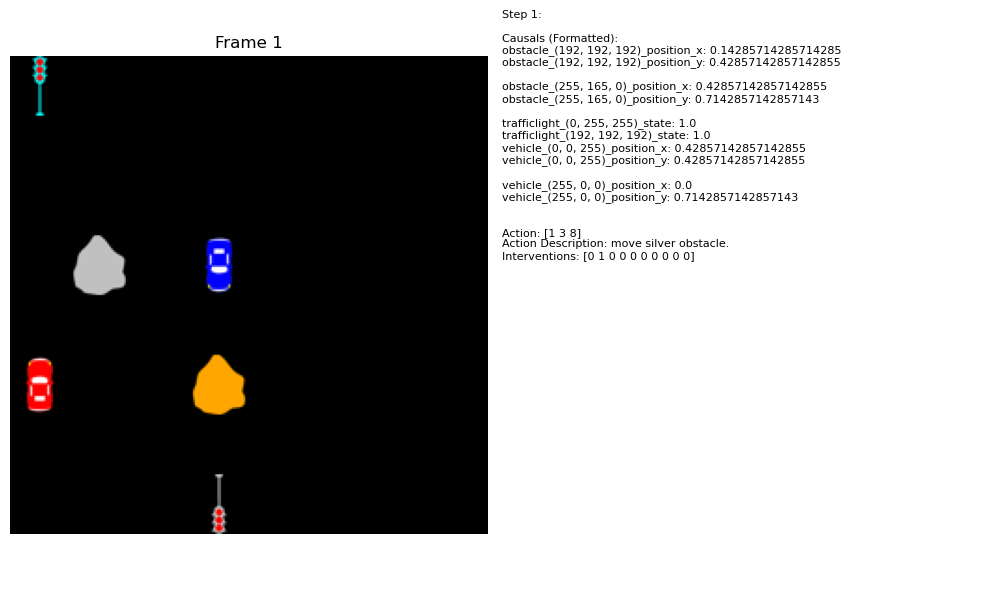

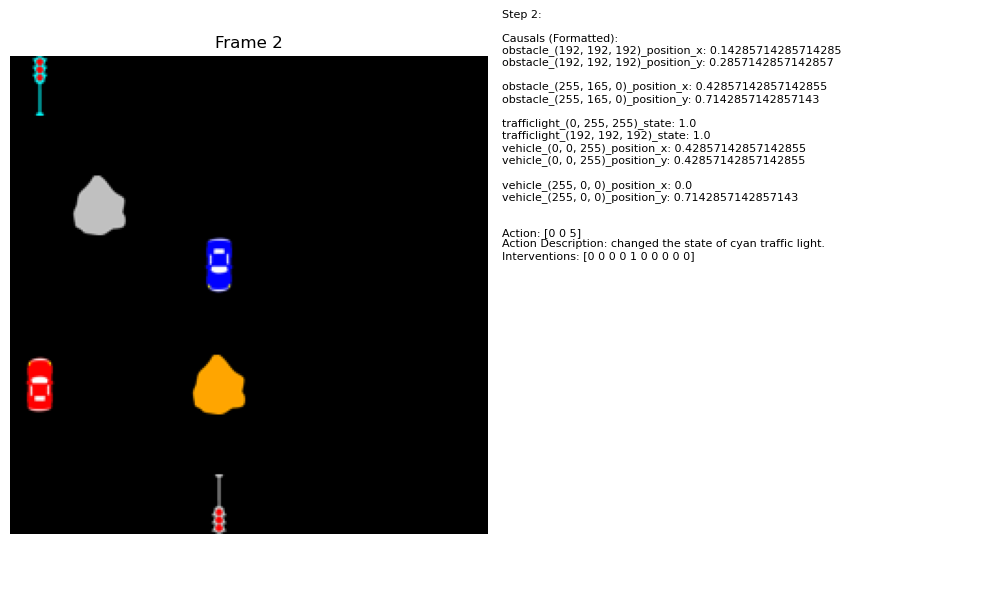

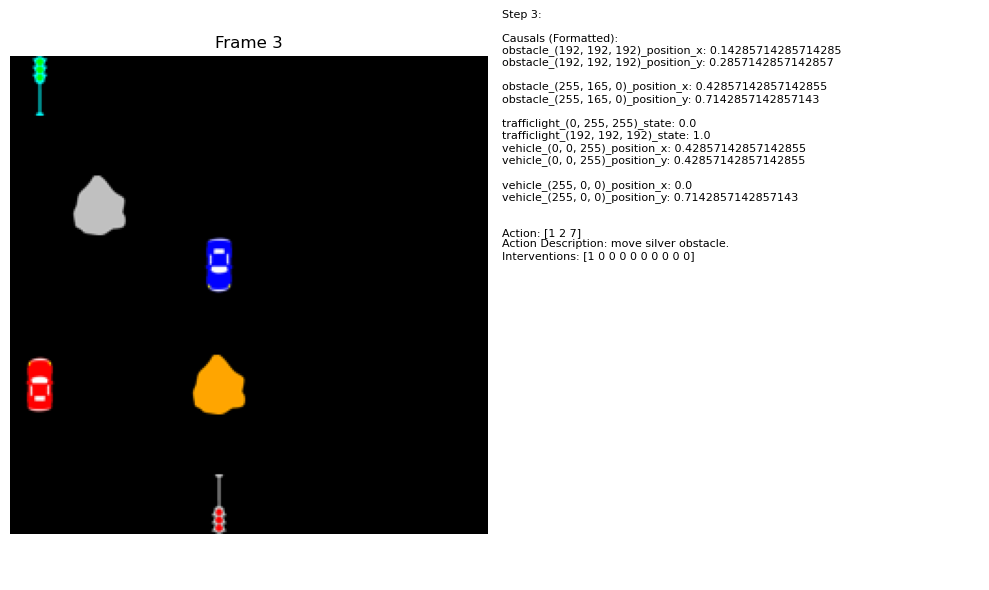

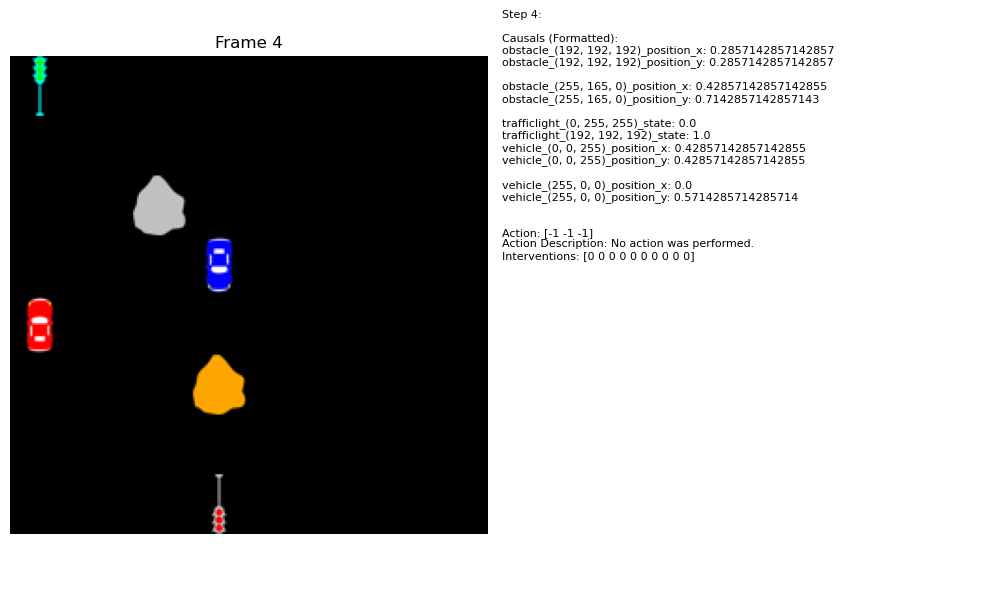

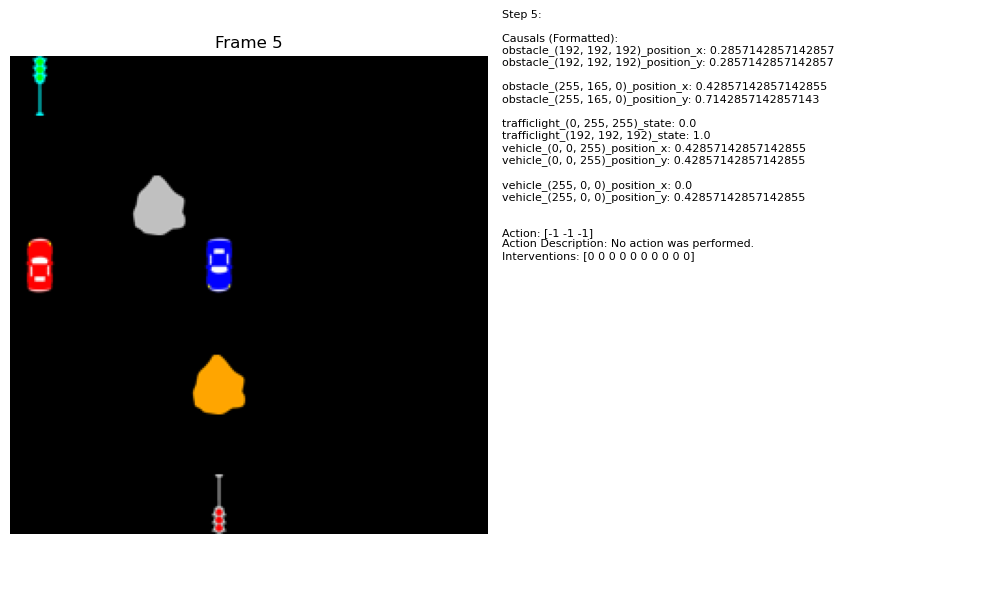

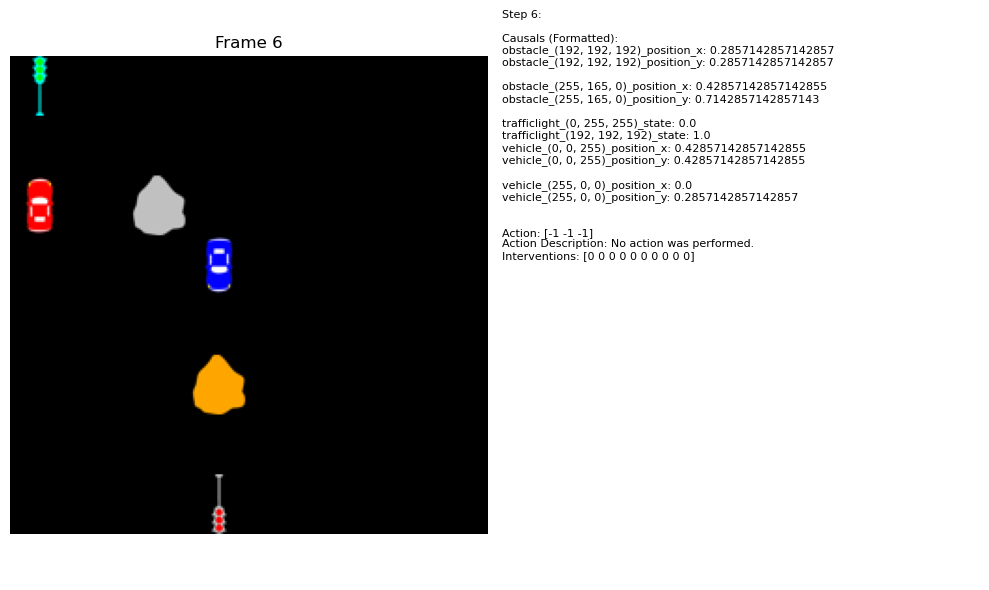

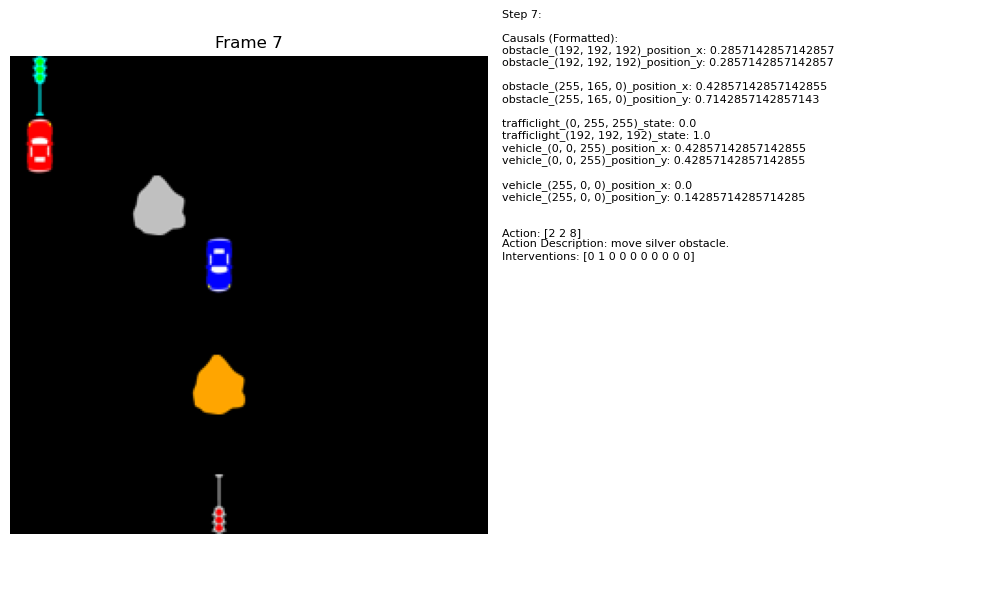

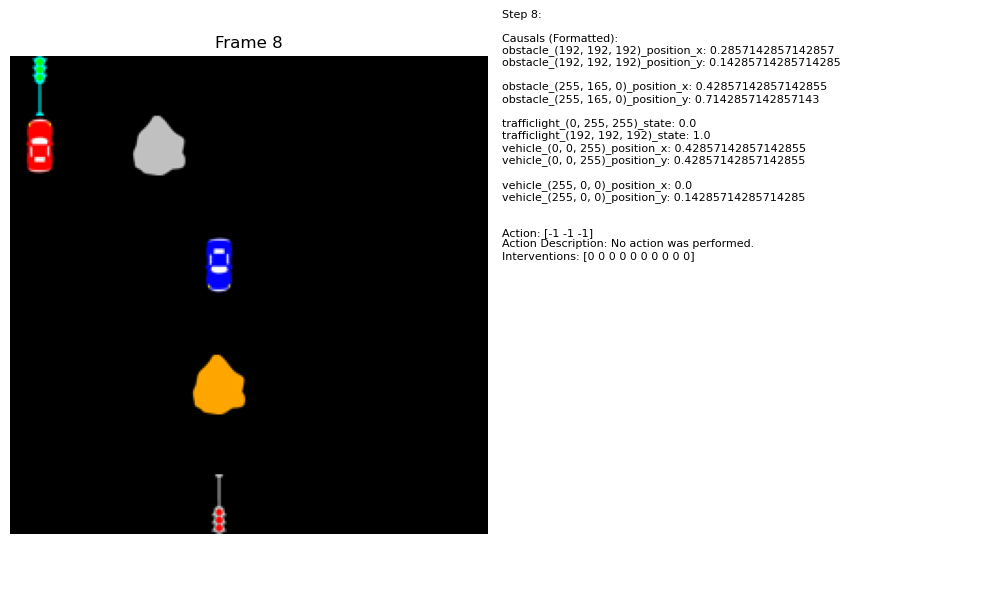

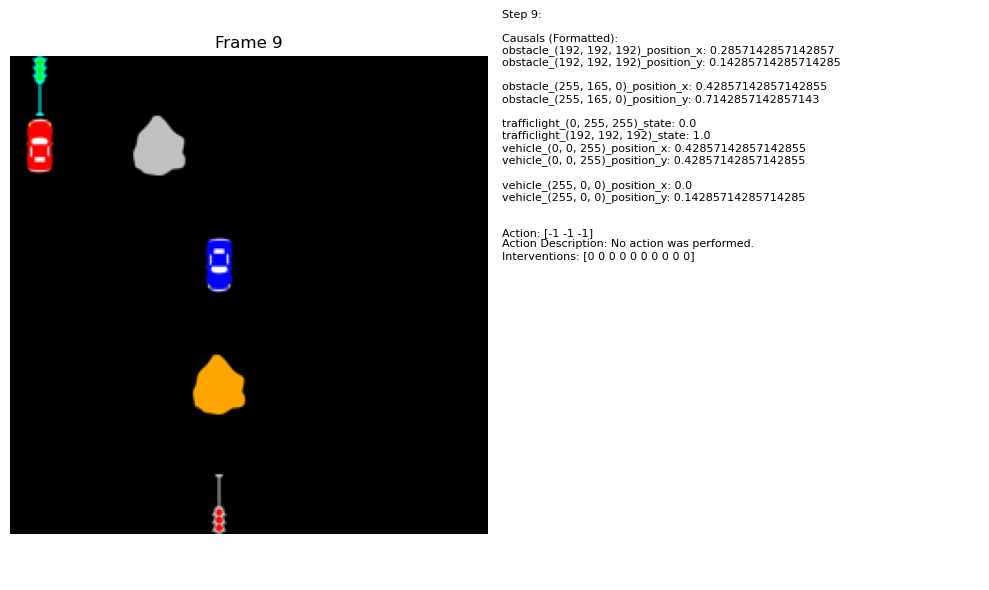

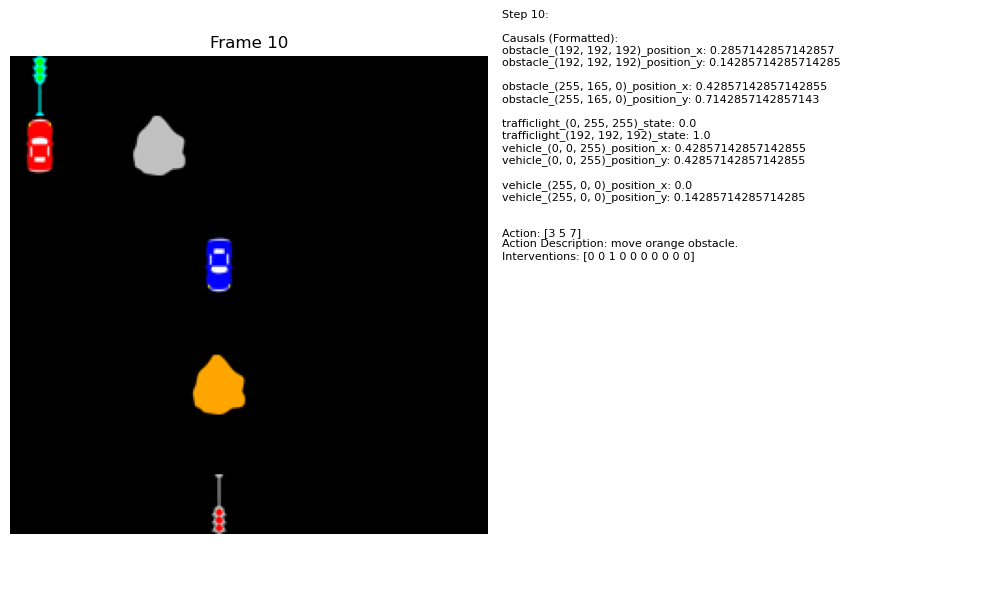

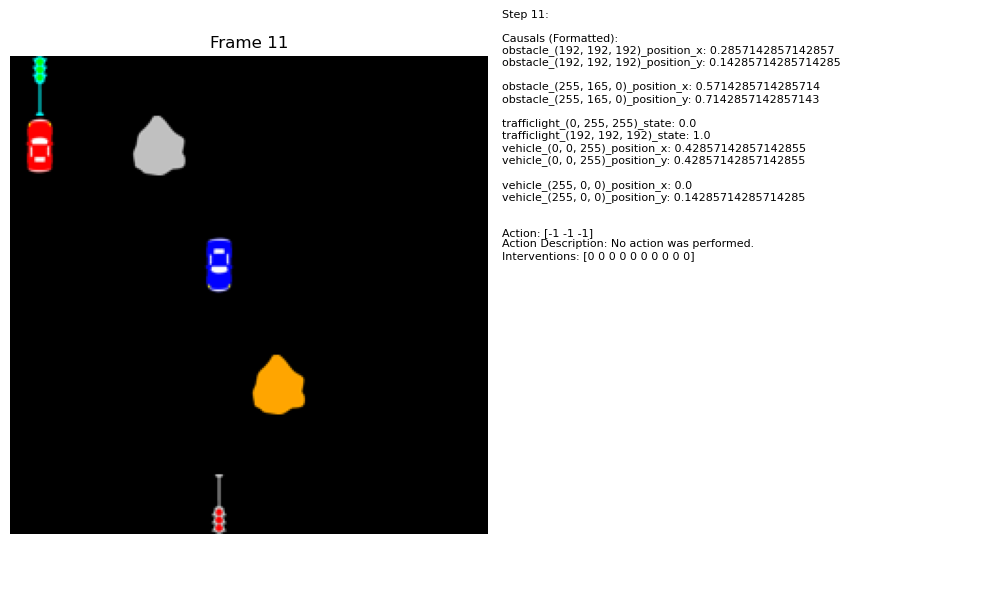

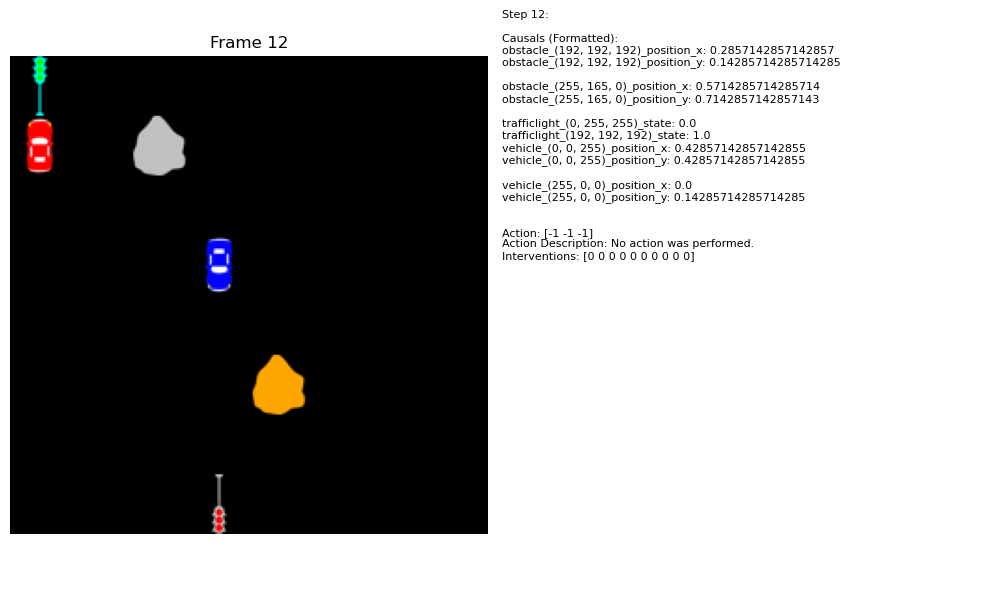

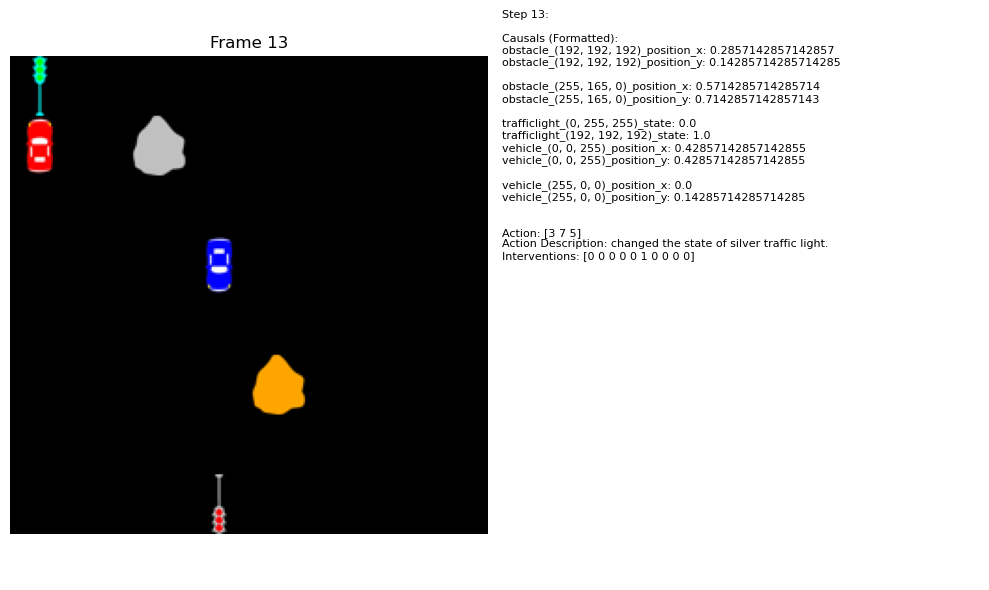

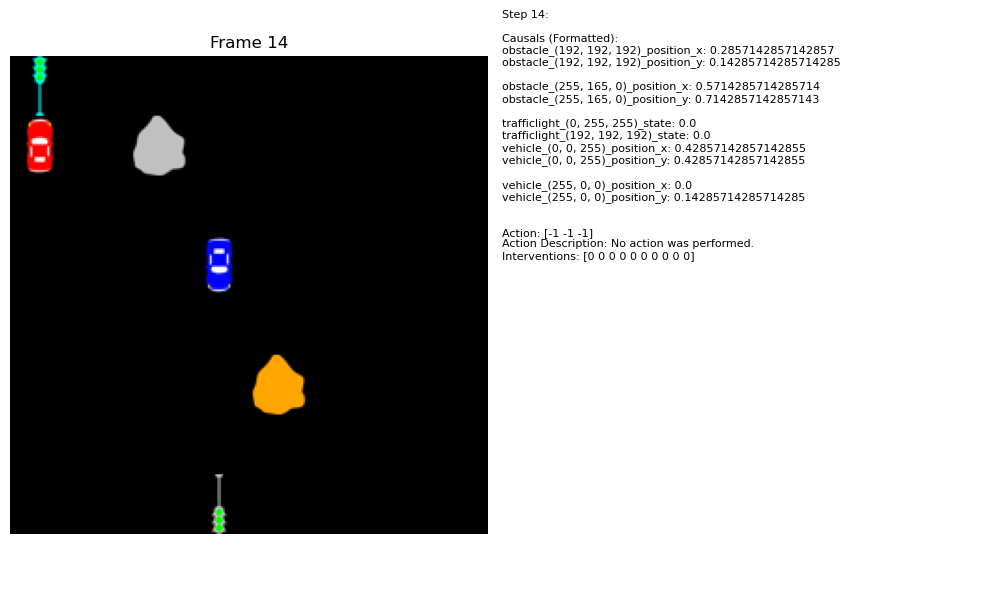

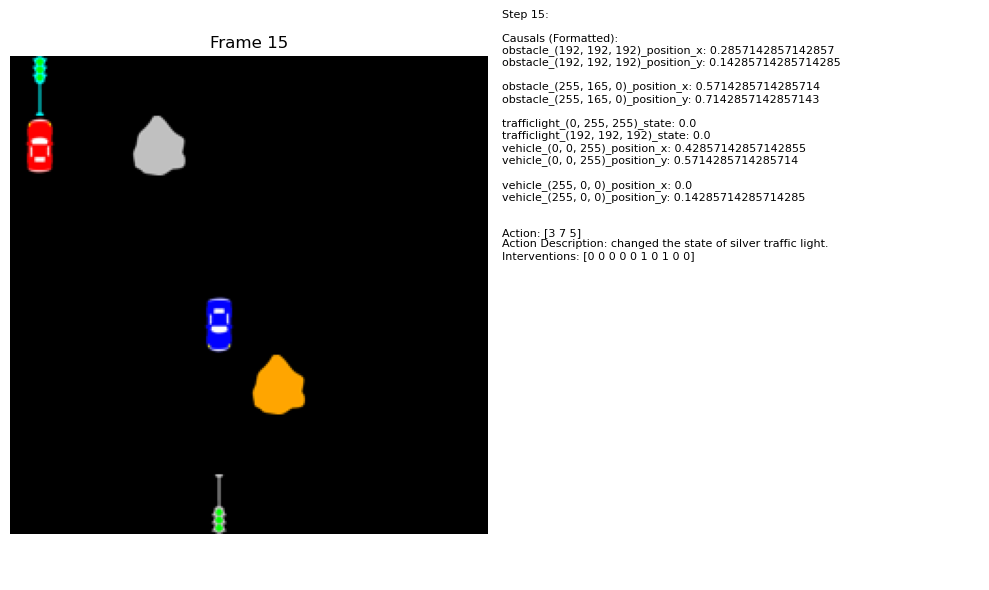

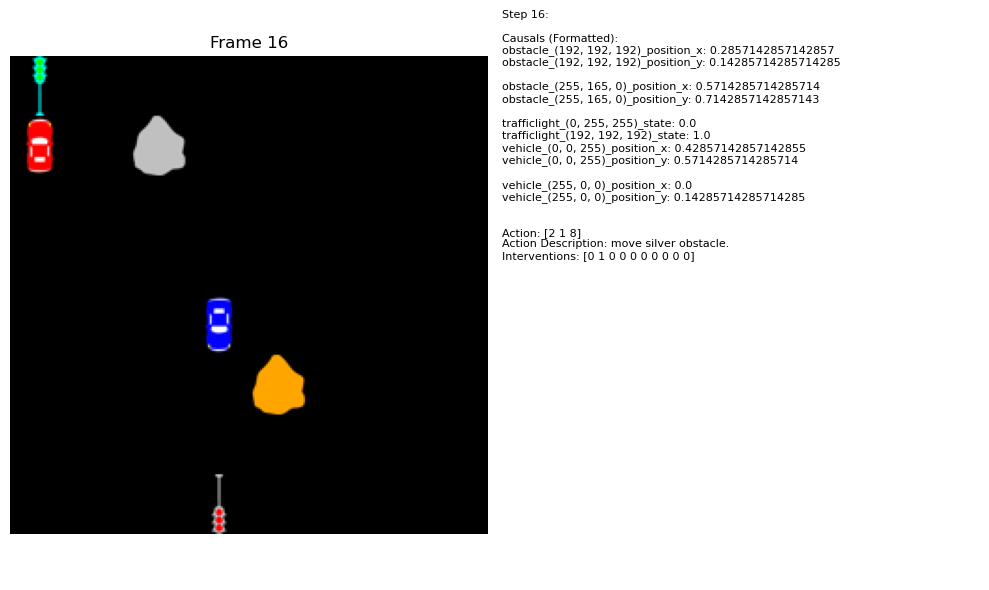

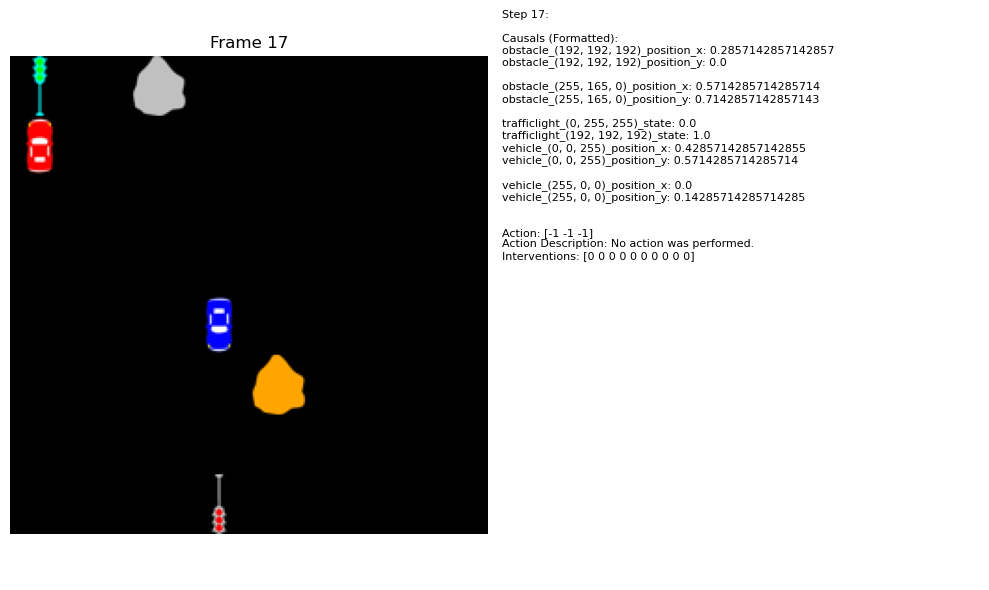

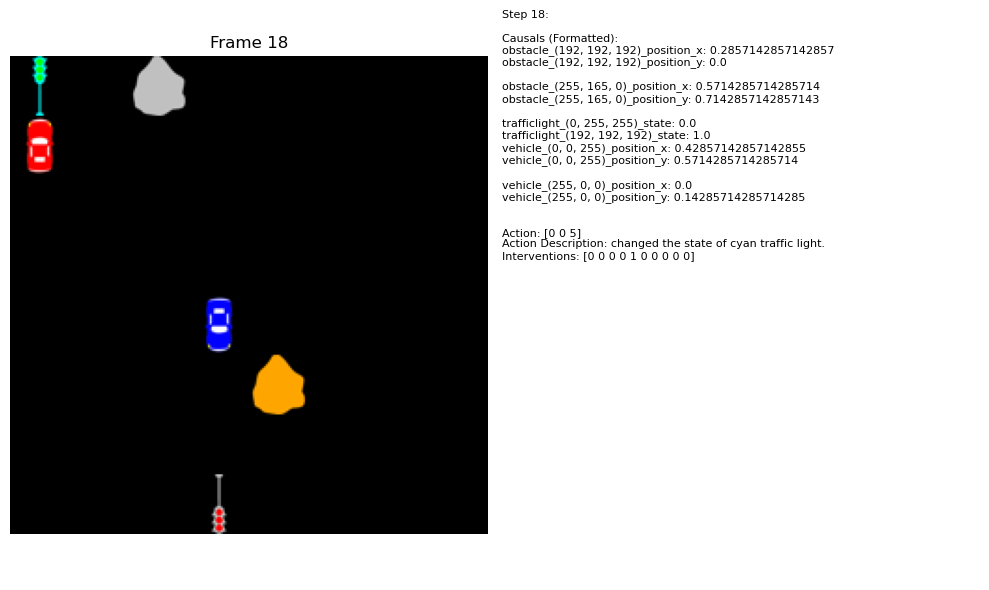

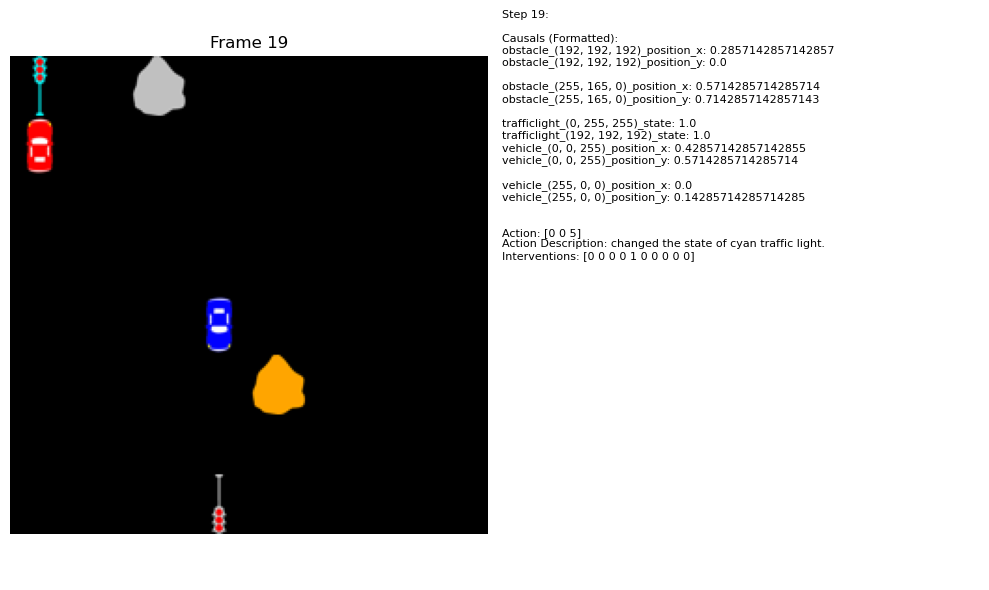

IndexError: index 19 is out of bounds for axis 0 with size 19

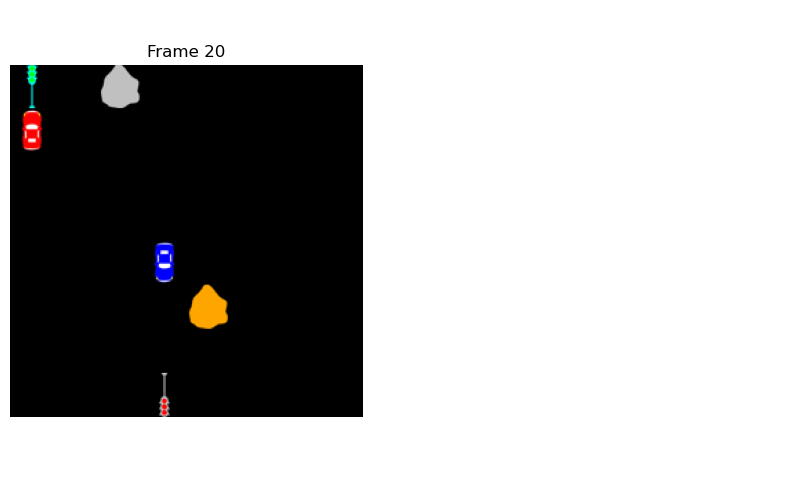

In [2]:
import numpy as np
import json
from gridworld import Gridworld
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]text_encoder}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

a = np.load('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified_2c2b2l_noturn_shufflecars/val/gridworld_episode_10002.npz')
causal_keys = json.load(open('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified_2c2b2l_noturn_shufflecars/val_metadata.json'))['causal_keys']
frames, causals, actions, interventions, action_descriptions = a['frames'], a['causals'], a['actions'], a['interventions'], a['action_descriptions']
visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions)

In [ ]:
from datasets import GridworldDataset, iTHORDataset
import torch

val_seq_dataset_gridworld = GridworldDataset(
	data_folder=args.data_dir, split='val', single_image=False, triplet=False, seq_len=args.seq_len, cluster=args.cluster, return_text=args.text, subsample_percentage=1.0, **dataset_args)